# Adult Dataset Preprocessing

#### Trustworthy AI Examples Series

This notebook walks through an example of the complete preprocessing pipeline used for the UCI Adult dataset.
We cover missing value handling, encoding, scaling, feature selection, correlation analysis, and fairness-aware diagnostics.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Setup and Imports

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

In [2]:
from python.utils.preprocessing import load_data, handle_missing_values, detect_column_types, encode_categorical_data, scale_features, feature_selection, split_data, correlation_matrix, identify_proxy_variables, frequency_distribution

## Data Loading

The UCI Adult dataset is composed of a pre-split train and test set. In this example, both datasets are combined to simplify the preprocessing pipeline. Each dataset contains the following features:

- age: Continuous age in years
- workclass: Categorical employment industry/sector
- fnlwgt: Estimated number of people in the US population that row represents
- education: Categorical highest education level
- education_num: Ordinal years of education
- marital_status: Categorical marital status (i.e. husband, wife)
- occupation: Categorical occupation type
- relationship: Categorical household role
- race: Categorical race
- sex: Categorical gender
- capital_gain: Continuous capital gains income
- capital_loss: Continuous capital losses
- hours_per_week: Continuous weekly working hours
- native_country: Categorical country of origin
- target: Binary income class; average yearly income of people that row represents

In [3]:
import pandas as pd

train_data = load_data(PROJECT_ROOT / 'data/adult_train.csv')
test_data = load_data(PROJECT_ROOT / 'data/adult_test.csv')

data = pd.concat([train_data, test_data], ignore_index=True)

data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
2,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
3,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
4,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K


## Missing Value Handling

Various strategies can be taken for addressing missing values in a dataset. In this example, missing values were filled with the mean of its respective column to avoid data loss. However, this technique may vary depending on the intended usage of a given dataset.

The function `handle_missing_values` supports three strategies: dropping rows with missing values, filling missing values with the column mean, and filling missing values with the column median.

In [4]:
processed_data = handle_missing_values(data, strategy='mean')

processed_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
2,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
3,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
4,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K


## Categorical Encoding

Common machine learning algorithms like linear regression, decision trees, neural networks, and support vector machines can only operate on numerical inputs and cannot interpret raw text or categorical labels. As such, categorical features must be converted into numerical representations before applying vector-based machine learning algorithms.

Ordinal encoding, as shown in the example below, assigns an integer value to each categorical type within a categorical column. Another method, known as one-hot encoding, flattens each categorical column into a series of binary columns (one for each categorical type), where a value of 1 indicates the presence of that category and 0 indicates no presence of the category.

In [5]:
encoded_data = encode_categorical_data(processed_data, method='ordinal')

encoded_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,7.0,77516,9.0,12.0,5.0,1.0,1.0,6.0,1.0,2174,0,40,39.0,0.0
1,37,4.0,284582,12.0,13.0,2.0,4.0,5.0,6.0,0.0,0,0,40,39.0,0.0
2,49,4.0,160187,6.0,4.0,4.0,8.0,1.0,4.0,0.0,0,0,16,23.0,0.0
3,37,4.0,280464,15.0,9.0,2.0,4.0,0.0,4.0,1.0,0,0,80,39.0,1.0
4,30,7.0,141297,9.0,12.0,2.0,10.0,0.0,3.0,1.0,0,0,40,19.0,1.0


## Feature Scaling

When numerical features vary widely in scale, the larger‑magnitude feature may dominate the model's calculations and skew its predictions in favor of that feature, regardless of its true importance. Features are often scaled in machine learning to avoid overweighting any specific feature, which ensures that each feature contributes equally to the model. 

Common feature-scaling methods include normalization, which rescales values to a fixed interval (usually 0–1), and standardization, which shifts features to have zero mean and unit variance.

In [6]:
scaled_data = scale_features(encoded_data, method='normalize', exclude_cols=['target'])

scaled_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,target,age,fnlwgt,capital_gain,capital_loss,hours_per_week,native_country
0,7.0,9.0,12.0,5.0,1.0,1.0,6.0,1.0,0.0,0.301370,0.044131,0.02174,0.0,0.397959,0.951220
1,4.0,12.0,13.0,2.0,4.0,5.0,6.0,0.0,0.0,0.273973,0.184219,0.00000,0.0,0.397959,0.951220
2,4.0,6.0,4.0,4.0,8.0,1.0,4.0,0.0,0.0,0.438356,0.100061,0.00000,0.0,0.153061,0.560976
3,4.0,15.0,9.0,2.0,4.0,0.0,4.0,1.0,1.0,0.273973,0.181433,0.00000,0.0,0.806122,0.951220
4,7.0,9.0,12.0,2.0,10.0,0.0,3.0,1.0,1.0,0.178082,0.087281,0.00000,0.0,0.397959,0.463415


## Feature Selection

As datasets grow in dimensionality, not all features contribute useful information, as some can introduce noise or redundancy that negatively impacts model performance. Feature selection identifies and retains the most informative predictors, which improves model accuracy and reduces overfitting.

Recommended selection functions depend on the task. For classification problems, statistical tests like ANOVA F-test are commonly used, while regression tasks often rely on F-regression or mutual information scores to identify the most relevant features.

The UCI Adult dataset is used for a classification task. In this example, a top‑k value of 15 is chosen during feature selection to ensure that all available features are retained for fairness assessment.

In [7]:
final_data = feature_selection(scaled_data, target_col='target', k=15, method='classification')

final_data.head()

,workclass,education,education_num,marital_status,occupation,relationship,race,sex,target,age,fnlwgt,capital_gain,capital_loss,hours_per_week,native_country
0,7.0,9.0,12.0,5.0,1.0,1.0,6.0,1.0,0.0,0.301370,0.044131,0.02174,0.0,0.397959,0.951220
1,4.0,12.0,13.0,2.0,4.0,5.0,6.0,0.0,0.0,0.273973,0.184219,0.00000,0.0,0.397959,0.951220
2,4.0,6.0,4.0,4.0,8.0,1.0,4.0,0.0,0.0,0.438356,0.100061,0.00000,0.0,0.153061,0.560976
3,4.0,15.0,9.0,2.0,4.0,0.0,4.0,1.0,1.0,0.273973,0.181433,0.00000,0.0,0.806122,0.951220
4,7.0,9.0,12.0,2.0,10.0,0.0,3.0,1.0,1.0,0.178082,0.087281,0.00000,0.0,0.397959,0.463415


## Correlation Analysis

Correlation analysis helps uncover relationships between features by measuring how strongly pairs of variables move together. In a fairness context, it can reveal redundant predictors that mask sensitive attributes or proxy variables that indirectly encode protected information. By examining a correlation matrix and flagging feature pairs with high absolute correlation, you can decide whether to drop or combine variables to reduce multicollinearity and unintended bias. This step ensures that your model's decisions are not unduly influenced by hidden dependencies among features.

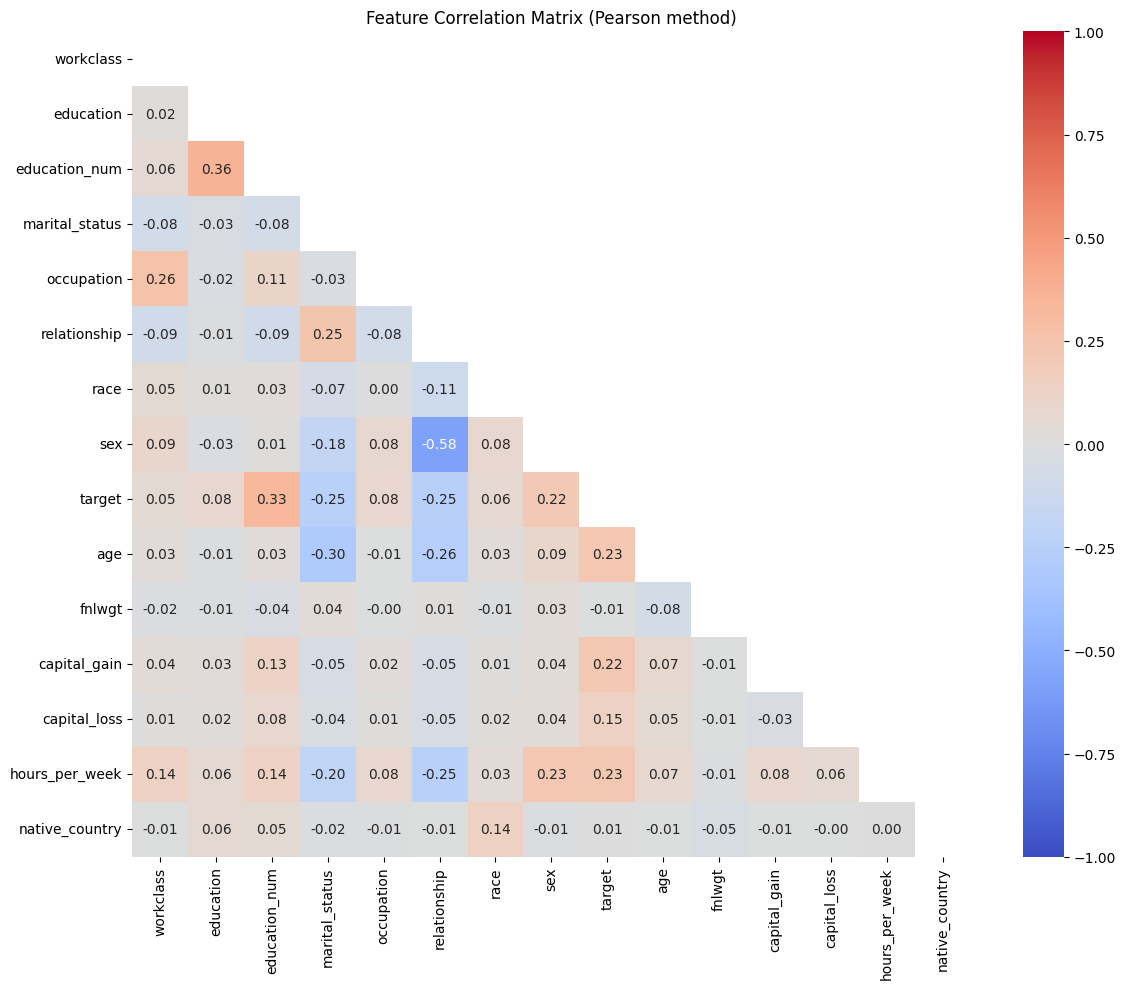

In [8]:
corr_matrix, high_corr_pairs = correlation_matrix(final_data, method='pearson', threshold=0.7, plot=True)

## Proxy Variable Identification

Even after removing explicit sensitive attributes, models may still be prone to bias through secondary exposure. Proxy variables are features that correlate strongly with protected characteristics like race, sex, or age. The `identify_proxy_variables` function computes Spearman rank correlations between each sensitive attribute and all other features, then surfaces the top matches. By reviewing the resulting `proxy_dict`, you can decide which proxies to drop or transform to prevent indirect bias from slipping into your model.

This function supports two methods: 'absolute', which flags features exceeding a fixed correlation threshold, and 'relative', which returns the top-k most correlated features for each sensitive attribute, even if those correlations are modest.

In this example, a relative method of proxy variable detection flagged native country, relationship, marital status, and years of education as potential proxy variables of race, sex, age, and education level respectively.

In [9]:
proxy_dict = identify_proxy_variables(final_data, ['race', 'sex', 'age', 'education'], method='relative', threshold=0.8, top_k=1)

proxy_dict.items()

dict_items([('race', ['native_country']), ('sex', ['relationship']), ('age', ['marital_status']), ('education', ['education_num'])])

## Frequency Distribution of Sensitive Attributes

Visualizing the frequency distribution of sensitive attributes is important for identifying class imbalances that can lead to biased model outcomes if left unaddressed. By using `frequency_distribution`, we generate counts and bar plots for each sensitive feature, making it easy to spot under‑ or over‑represented groups.

In this example, distribution plots of race, sex, and education show stark disparities in representation, which would pose potential fairness risks if not addressed before training a model.

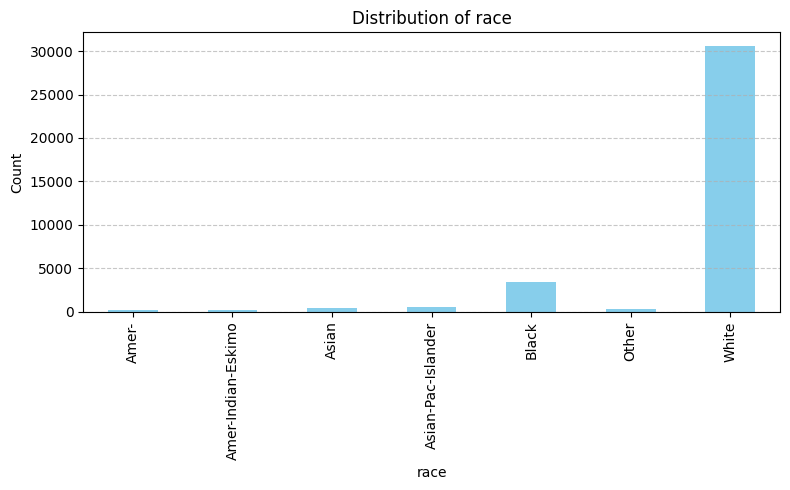

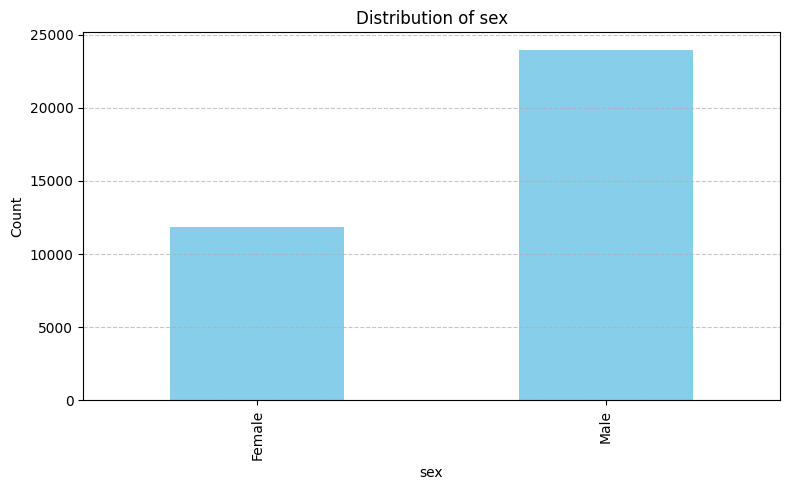

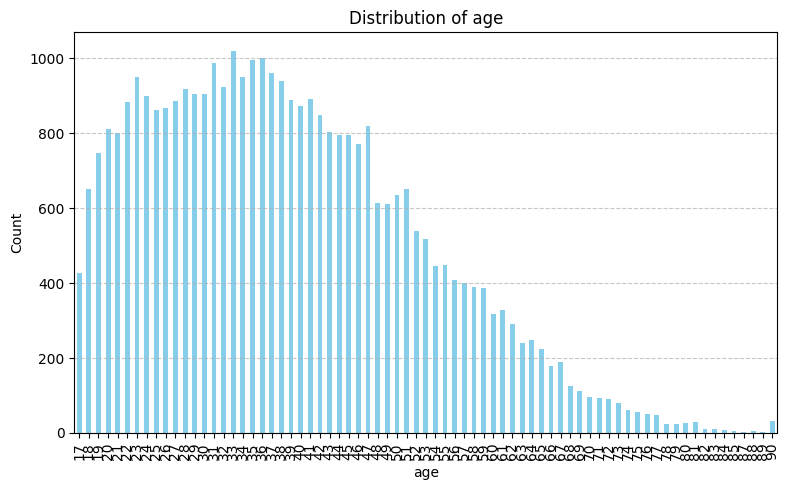

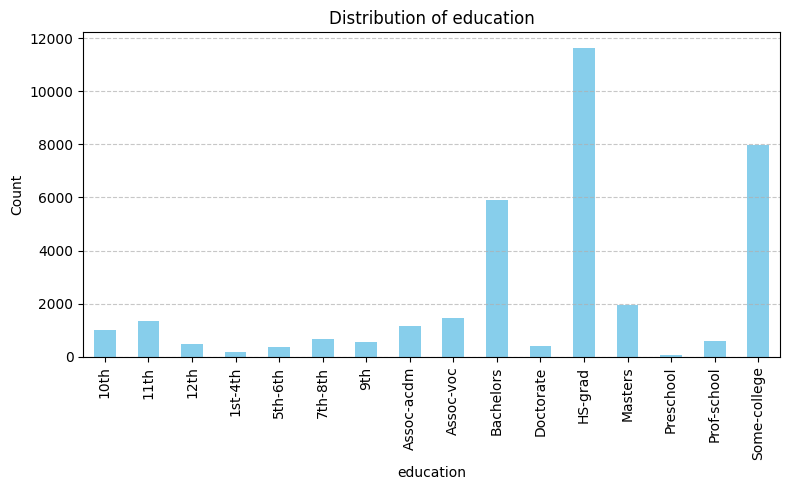

In [10]:
dist_dict = frequency_distribution(processed_data, ['race', 'sex', 'age', 'education'], plot=True)

## Train & Test Set Splitting

Properly splitting your data into training and testing sets is crucial for evaluating model performance on unseen examples and guarding against overfitting. The `split_data` function holds out a random 20% of the fully preprocessed dataset for testing, while training on the remaining 80%.

Maintaining the same feature set and preserving group proportions across sensitive attributes ensures that fairness metrics computed on the test set truly reflect how the model will behave in real‑world scenarios. Finally, fixing a random state guarantees reproducible splits for consistent benchmarking across experiments.

In [11]:
X_train, X_test, y_train, y_test = split_data(final_data, target_col='target', test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1] if X_train.shape[1] == X_test.shape[1] else -1}")

Training set size: 28654 samples
Test set size: 7164 samples
Number of features: 14
